In [1]:
# !pip install scikit-image

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-09-13 09:26:50.904768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 09:26:53.929821: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-09-13 09:26:53.929975: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-09-13 09:26:53.933981: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-09-13 09:26:54.533835: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


# Image Augmentation
* 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [4]:
image = load_img("./catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

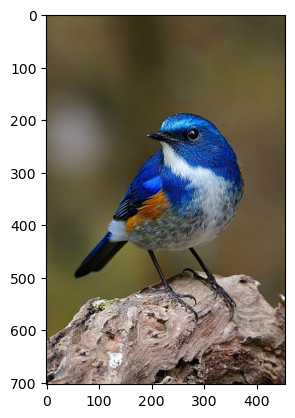

In [5]:
plt.imshow(image)
plt.show()

In [6]:
datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

In [7]:
image_array.reshape((1,) + image_array.shape).shape

(1, 703, 454, 3)

In [8]:
image_array.shape

(703, 454, 3)

In [9]:
image_array = image_array.reshape((1,) + image_array.shape)

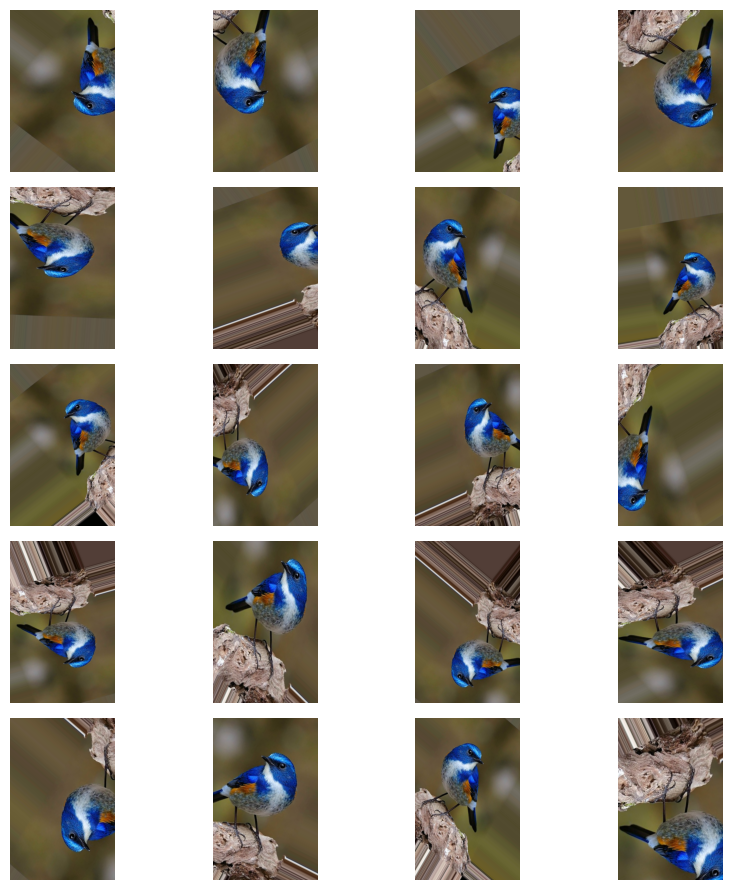

In [10]:
fig, axes = plt.subplots(5, 4, figsize=(9,9))
axes = axes.ravel()

for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
    if i >= 20:   # 20개 이미지 생성 후 종료
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 전이학습 
* 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 훈련하거나 결과를 출력

In [13]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet152V2
import tensorflow as tf

# GPU 디바이스 설정
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [14]:
base_model = ResNet50(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

2024-09-13 09:27:22.204344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 09:27:22.208046: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon(TM) Graphics)
2024-09-13 09:27:22.298553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 09:27:22.298618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


102967424/102967424 [==============================] - 4s 0us/step


In [15]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [16]:
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(2, activation='sigmoid'))
# model.summary()

In [17]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet50_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [18]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [19]:
train = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

train_gen = train.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [20]:
valid = ImageDataGenerator(rescale=1.0/255)
valid_gen = valid.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [21]:
history=model.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000


2024-09-13 09:27:35.176172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 09:27:35.586492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 09:27:35.586554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5273

2024-09-13 09:27:47.774756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 09:27:48.116334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 09:27:48.116397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - 24s 15s/step - loss: 0.6930 - accuracy: 0.5273 - val_loss: 0.6929 - val_accuracy: 0.5273
Epoch 2/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6928 - val_accuracy: 0.5273
Epoch 3/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6927 - val_accuracy: 0.5273
Epoch 4/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6927 - accuracy: 0.5273 - val_loss: 0.6926 - val_accuracy: 0.5273
Epoch 5/2000
2/2 [==============================] - 19s 14s/step - loss: 0.6926 - accuracy: 0.5273 - val_loss: 0.6926 - val_accuracy: 0.5273
Epoch 6/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6926 - accuracy: 0.5273 - val_loss: 0.6925 - val_accuracy: 0.5273
Epoch 7/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6925 - accuracy: 0.5273 - val_loss: 0.6925 - val_accuracy: 0.5273
Epoch 8/2000
2/2 [========

Epoch 59/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6916 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 60/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6916 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 61/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6916 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 62/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 63/2000
2/2 [==============================] - 18s 13s/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 64/2000
2/2 [==============================] - 18s 13s/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 65/2000
2/2 [==============================] - 19s 13s/step - loss: 0.6915 - accuracy: 0.5273 - val_loss: 0.6915 - val_accuracy: 0.5273
Epoch 

2024-09-13 10:12:11.035411: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: './catanddog/train/Dog/976.jpg'
Traceback (most recent call last):

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 1050, in

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: './catanddog/train/Dog/976.jpg'
Traceback (most recent call last):

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: './catanddog/train/Dog/976.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: './catanddog/train/Dog/976.jpg'
Traceback (most recent call last):

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/user/miniforge3/envs/dml/lib/python3.9/site-packages/keras/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: './catanddog/train/Dog/976.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_11362]

# Resnet

In [22]:
base_model2 = ResNet152V2(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

242745792/242745792 [==============================] - 9s 0us/step


In [23]:
base_model2.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_blo

                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
          

 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block10_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 14, 14, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block12_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 conv4_block15_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block18_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block20_2_relu[0][0]']   
                                )                                                                 
          

                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 14, 14, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_block26_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block25_out[0][0]']      
 Normalization)                 )                                                                 
          

                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block28_2_pad[0][0]']    
                                                                                                  
 conv4_block28_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_2_conv[0][0]']   
 lization)

                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block31_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block33_2_relu[0][0]']   
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block36_1_bn[0][0]']     
 on)                                                                                              
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
          

In [24]:
base_model2.trainable = False
model2 = Sequential()
model2.add(base_model2)
model2.add(Dense(2, activation='sigmoid'))
# model.summary()

In [25]:
model2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet152V2_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [26]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [ ]:
history2=model2.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000


2024-09-13 10:25:56.554584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 10:25:57.762926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 10:25:57.762992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5558 

2024-09-13 10:26:16.351785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-13 10:26:17.420810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 10:26:17.420901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14845 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


2/2 [==============================] - 44s 26s/step - loss: 0.6918 - accuracy: 0.5558 - val_loss: 0.6897 - val_accuracy: 0.6260
Epoch 2/2000
2/2 [==============================] - 34s 25s/step - loss: 0.6918 - accuracy: 0.5688 - val_loss: 0.6889 - val_accuracy: 0.6519
Epoch 3/2000
2/2 [==============================] - 34s 25s/step - loss: 0.6905 - accuracy: 0.5922 - val_loss: 0.6881 - val_accuracy: 0.6779
Epoch 4/2000
1/2 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5838